# Capstone Project Report - The Battle of Neighborhoods (week 2)

## Table of contents
* [Introduction: Background and Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Data Analysis](#analysis)
* [Results and Discussion](#result)
* [Conclusion](#conclusion)

## 1. Introduction: Background and Business Problem <a name="introduction"></a>

A description of the problem and a discussion of the background.
A description of the data and how it will be used to solve the problem.

**Background**  
   Melbourne is an international city and the capital of Victoria State, Australia. The city is famous for all types of events and cultral festivals, attracting over 10 millions of tourists from Australia and around the world in 2019 (source: https://www.finder.com.au/press-release-jan-2019-10-million-tourists-to-visit-australia-in-2019). In addition, Melbourne has dominated Australia's population growth (http://worldpopulationreview.com/world-cities/melbourne-population/), which is estimated around 4.967 millions by 2020 and will increase to around 5.39 millions by 2025. The large number of visitors and new population bring in increasing demands and opportunities for catering business. Among the international tourists and local population growth, people of Asian ethnics have become a major source, with Chinese visitors and immigrants being the dominant contributor.

**Business Problem**  
This report will try to find potential places for the stakeholders to start a **Chinese restaurant** targeting **mid/high-end customers** in Melbourne.

Ideally, the location should be within 20 min driving distance to Melbourne CBD. The location should be chosen in a neibourhood with a middle to high level of population and above mid-level income. The location of the new restaurant should be chosen in a neibourhood with low crime rate and easy accessibility.



## 2. Data  <a name="data"></a>

To find the optimal location for the new Chinese restaurant targeting mid to high level customers, we need to understand the social-geo-economical distribution of Melbourne suburbs. The selection of the restaurant location requires some comprehensive analysis of the suburbs' data https://www.fsrmagazine.com/expert-takes/8-factors-choosing-new-restaurant-location. In this project, we will try to analyse the most important ones:  
1. *Visibility*. To analyse the visibility, we will use the data of local population http://data.id.com.au/idforecasts/ as well as the venue information returned from Foursquare. A direct counting of walkers' traffice is difficult, however, this can be estimated indirectly based on the local population and the number of venues, since the higher the population, the more venues, the larger number of people in that neighbourhood, and the more visible the restaurant will be.
2. *Affordability*. Since the target is to locate a restaurant for mid/high level customers, it is natural to find location close to suburbs that have a mid to high level income. The income data can be found at http://house.speakingsame.com/suburbtop.php?sta=vic&cat=Median%20household%20income&name=Weekly%20income&page=1
3. *Parking and Accessibility*. There is no need to explain why parking is important, especially for restaurant targeting mid/high level customers. The information of parking can be found using the Folium map.Ideally,the restaurant should be within walking distance from a car park, or located inside a shopping mall, where free or cheap parking is available. 
4. *Crime Rates*. Safety is important, it is essential to make sure the location selected for the restaurant has a reasonablly low crime rate.The crime rate data for different suburbs can be found at https://www.crimestatistics.vic.gov.au/explore-crime-by-location
5. *Surrounding Businesses and Competitor Analysis*. The data can be found using Foursquare. For restaurant location, there is a fine balance between 'assemble' and 'isolation'. People like to go to places with a lot of choices of restaurants, however, it is also important to avoid too many similar restaurant crowding at the same place. Therefore it is important to make sure that the location is nearby a 'food' area to be seen by more customers, yet avoid in close proximity to a similar restaurant that can cause a direct competition. 




## Methodology <a name="methodology"></a>

In this project, we will provide a bird eye view on the geo-social-economical information of Melbourne suburbs, in order to find a potential spot for a Chinese restaurant targeting mid to high level customers.

First, we will collect and clean the required data for geo-social-economical analysis, including crime rate, income and population distribution.

Second, we will perform basic statistics to understand the distribution of the data. Then we will filter and categorize the data based on income,population and distance to CBD. We will only filter suburbs with above middle levels of income, population, population growth, and located within 15 km distance from the CBD.

Third, we will visualize how different groups of data are distributed and clustered geographically using Folimn map. In order to maximize the potential income of the restaurant, we will use machine learning to find a centroid of the clusters of filtered suburbs, taking into account the weight of income and population (weighted k-mean clustering). This centroid will be the starting point for further analysis and searching.

Finally, we will use Foursquare API and Folium map to examine the restaurants around this centroid. Whether there is an assemble of "food street" or "food area" to attract customers? Whether there is any similar Chinese restaurant as competitors? Whether there is car park area near by? We will recheck if this suburbs is safe based on the crime rate data. After answering these questions, we will suggest the potential locations to the stake holders

## Analysis  <a name="analysis"></a>

Below we import and analyse the population data, income data and crime rate data 

In [490]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

import geocoder
import folium
mpl.style.use('ggplot') # optional: for ggplot-like style

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


In [491]:
# import excel data from local source
df_pop = pd.read_excel (r'D:\jon documents\GitHub\Coursera_Capstone\melbourne_population.xlsx')  
df_pop = df_pop.dropna()
df_pop = df_pop.reset_index(drop=True)

df_income = pd.read_excel (r'D:\jon documents\GitHub\Coursera_Capstone\melbourne_income.xlsx')
df_income = df_income.dropna()
df_income = df_income.reset_index(drop=True)

df_crime = pd.read_csv (r'D:\jon documents\GitHub\Coursera_Capstone\melbourne_crime.csv')

df_income.columns = ['Rank','Suburbs','Weekly Income']
df_pop.columns = ['Rank','Suburbs','2011','2021','2031','Population Growth (2011-2031)']



#### Crime rate distribution 

In [492]:
# only keep the information we want
df_crime_n = df_crime[df_crime.columns[df_crime.columns.isin(['Local Government Area', 'Rate per 100,000 population','Year'])]]
df_crime_n.head()

# convert the data to new form according to year
df_crime_r = pd.DataFrame(columns = ['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019'])
for gov,rate,year in zip(df_crime_n['Local Government Area'],df_crime_n['Rate per 100,000 population'],df_crime_n['Year']):
    
    # remove the space at the start of the suburb name
    if gov[0] == ' ':
        gov = gov[1:]
   
    df_crime_r.loc[gov,str(year)] = float(rate.replace(',', '')) 

df_crime_r.reset_index(inplace = True)
df_crime_r.rename(columns={'index':'Local Government Area'},inplace = True)
df_crime_r['Local Government Area'] = df_crime_r['Local Government Area'].str.upper()

Top 5 Local Government Area with the highest crime rate over the past three years from 2017 to 2019 

In [495]:
# show the crime rate for suburbs in descending order
df_crime_r['Mean rate over the past 3 years'] = df_crime_r.loc[:,'2017':'2019'].mean(axis = 1)
df_crime_r.sort_values(by='Mean rate over the past 3 years',ascending=False).reset_index(drop = True).head(5)


,Local Government Area,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Mean rate over the past 3 years
0,MELBOURNE,26613.6,24126.1,22588.3,20718.4,18581,18033.6,18691.8,16724.2,16129,14820.7,15891.300000
1,LATROBE,8297.5,9188.5,9771.1,10307.1,10280,11818.3,13533.5,12726.3,13137.7,13305,13056.333333
2,YARRA,11737.9,11068,11411.6,10640.5,11528.4,10881.5,11982.5,11154.9,11513.3,10905.6,11191.266667
3,MILDURA,8999.5,9065.6,8463.1,8467.5,8653.3,8388.7,9189.9,8998.6,9561.4,10102.2,9554.066667
4,GREATER SHEPPARTON,7582.6,7895.5,7843.4,7964.4,8645.3,8564.3,9440.3,9055.1,9346,9781.9,9394.333333


In [496]:
df_crime_r['Mean rate over the past 3 years'] = df_crime_r['Mean rate over the past 3 years'].astype(int)
df_crime_r.head()

,Local Government Area,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Mean rate over the past 3 years
0,PORT PHILLIP,8923.5,8501.6,8439,8954,8500.6,8935.8,9532.6,8964.7,8778.3,8364.7,8702
1,BASS COAST,6388.7,5404.7,5858.3,5812.1,6695.5,5801.8,6063.2,6025.7,4560.3,5258.7,5281
2,DAREBIN,6251.9,6537.6,6834.5,6269.4,7598.1,7259.1,8371.9,7525,7120.9,6968.4,7204
3,MONASH,3887.8,3741.3,3549.4,3676.3,3720.7,3799.1,4518.6,4290,4135.9,4297,4240
4,WANGARATTA,6154.4,6184.8,6188.5,6010.8,6137.4,5710.1,6169.6,6443,5982.1,5840.1,6088


The statistics of the crime rate is as follows:

In [497]:
df_crime_r.describe()

,Mean rate over the past 3 years
count,80.000000
mean,5699.725000
std,2362.270893
min,2160.000000
25%,4026.500000
50%,5262.000000
75%,6940.750000
max,15891.000000


We can visualize the crime rate on the map. First, we get the central location of the local government areas.

In [498]:
for i, lga in enumerate(df_crime_r['Local Government Area']):
    
    g = geocoder.arcgis('{}, Victoria'.format(lga))
    lat_lng_coords = g.latlng
    # loop until you get the coordinates
    j=0
    while(lat_lng_coords is None and j<10):
        print('*')
        j+=1
        g = geocoder.arcgis('{}, Victoria'.format(sub))
        lat_lng_coords = g.latlng
        
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    df_crime_r.loc[i,'Latitude']= latitude
    df_crime_r.loc[i,'Longitude']= longitude
        
    df_crime_r.loc[i,'Distance to CBD']= geopy.distance.vincenty((latitude,longitude),coord_CBD).km


In [499]:
df_crime_r.sort_values(by='Mean rate over the past 3 years',ascending=False).head(10)

,Local Government Area,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Mean rate over the past 3 years,Latitude,Longitude,Distance to CBD
53,MELBOURNE,26613.6,24126.1,22588.3,20718.4,18581,18033.6,18691.8,16724.2,16129,14820.7,15891,-37.81739,144.96751,0.000000
33,LATROBE,8297.5,9188.5,9771.1,10307.1,10280,11818.3,13533.5,12726.3,13137.7,13305,13056,-38.25379,146.46124,139.792763
60,YARRA,11737.9,11068,11411.6,10640.5,11528.4,10881.5,11982.5,11154.9,11513.3,10905.6,11191,-37.80491,145.00338,3.448998
66,MILDURA,8999.5,9065.6,8463.1,8467.5,8653.3,8388.7,9189.9,8998.6,9561.4,10102.2,9554,-34.18577,142.16202,475.710983
76,GREATER SHEPPARTON,7582.6,7895.5,7843.4,7964.4,8645.3,8564.3,9440.3,9055.1,9346,9781.9,9394,-36.42742,145.41519,159.305974
0,PORT PHILLIP,8923.5,8501.6,8439,8954,8500.6,8935.8,9532.6,8964.7,8778.3,8364.7,8702,-37.85874,144.96150,4.619967
36,SWAN HILL,8211.8,6451,6575.7,6537.2,7664.8,7849.5,7972.8,8428.1,8719.1,8819.5,8655,-35.34098,143.56160,302.233008
77,GREATER DANDENONG,7730.4,7695.2,7914.4,8422.8,7841.7,8428.1,9430.7,8681,8388.6,8695.9,8588,-38.00112,145.19073,28.305773
14,BALLARAT,8700.8,8558.1,8439.1,8326.9,7442.4,8492.4,8894.7,8849.2,7563,7823.7,8078,-37.56225,143.84716,102.792908
40,WARRNAMBOOL,6336.1,5568.3,5683.8,5711.6,5544.2,6290.3,6994.3,7793.1,7848.1,7986.7,7875,-38.38408,142.48337,226.778411


We then look at the income and population distribution.

#### Income distribution

In [500]:
df_income.head(10)
#df_income.loc[df_income.Suburbs == 'melbourne']

,Rank,Suburbs,Weekly Income
0,1,Canterbury,2352
1,2,Park Orchards,2329
2,3,Wonga Park,2221
3,4,Brighton,2200
4,5,Camberwell,2122
5,6,Albert Park,2103
6,6,Middle Park,2103
7,7,North Warrandyte,2074
8,7,Warrandyte,2074
9,8,Kooyong,2047


#### Population distribution

In [501]:
df_pop.head(10)

,Rank,Suburbs,2011,2021,2031,Population Growth (2011-2031)
0,1,Tarneit,21566.0,44509.0,74932.0,53366.0
1,2,Wollert,871.0,17960.0,50685.0,49814.0
2,3,Rockbank,1419.0,7330.0,45305.0,43886.0
3,4,Melton South,9054.0,26694.0,47002.0,37948.0
4,5,Officer,1894.0,15391.0,39495.0,37601.0
5,6,Clyde North,235.0,9115.0,36439.0,36204.0
6,7,Wyndham Vale,17212.0,37047.0,47452.0,30240.0
7,8,Craigieburn,32700.0,53748.0,60806.0,28106.0
8,9,Melbourne,34383.0,49991.0,62077.0,27694.0
9,10,Sunbury,35060.0,42996.0,60096.0,25036.0


In [502]:
# drop the column 'Rank' 
df_pop = df_pop.drop('Rank',axis =1)
df_income = df_income.drop('Rank',axis =1)


In [503]:
# set suburbs information to lowercase
df_pop['Suburbs'] = df_pop['Suburbs'].str.lower() 
df_income['Suburbs'] = df_income['Suburbs'].str.lower() 


In [504]:
# combine the  datasets of population and income
pop_income = pd.merge(df_income,df_pop,on='Suburbs',sort=False,how='inner')#.set_index('Suburbs')
print(pop_income.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 0 to 379
Data columns (total 6 columns):
Suburbs                          380 non-null object
Weekly Income                    380 non-null int64
2011                             380 non-null float64
2021                             380 non-null float64
2031                             380 non-null float64
Population Growth (2011-2031)    380 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 20.8+ KB
None


We can now do some basic statastical analysis to the dataframe

In [505]:
pop_income.describe()

,Weekly Income,2011,2021,2031,Population Growth (2011-2031)
count,380.000000,380.000000,380.000000,380.000000,380.000000
mean,1352.289474,10458.905263,11930.815789,13165.547368,2706.642105
std,307.826949,9006.705267,10674.965906,12280.329474,5729.019623
min,633.000000,109.000000,233.000000,264.000000,-2081.000000
25%,1172.000000,3748.000000,3991.000000,4270.250000,237.500000
50%,1348.500000,8007.500000,8662.000000,9277.500000,1069.500000
75%,1512.000000,14437.500000,16511.000000,18291.250000,2660.500000
max,2352.000000,49796.000000,54498.000000,74932.000000,53366.000000


We use distribution plots in combine with box plots to visualise the distributions of Crime Rate, Weekly Income, Population and Population growth.

[Text(0.5, 0, 'Averaged Crime Rate from 2017 - 2019')]

C:\Program Files (x86)\Python\WPy-3670\python-3.6.7.amd64\lib\site-packages\matplotlib\figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


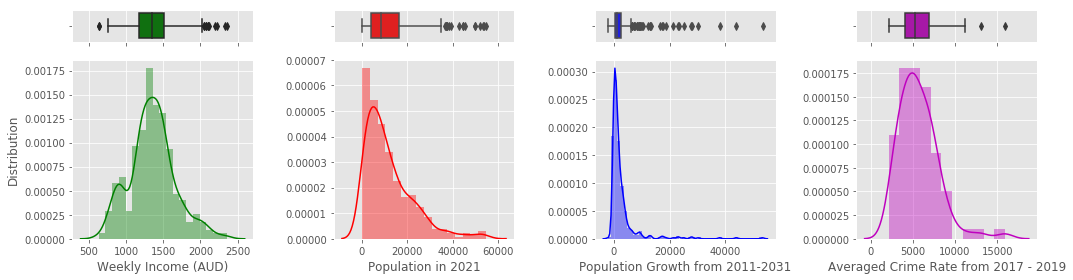

In [377]:

f, ax = plt.subplots(2,4, sharex='col', figsize=(15, 4),gridspec_kw={"height_ratios": (.15, .85)},tight_layout = True)
# Add a graph in each part
sns.boxplot(pop_income[['Weekly Income']], ax=ax[0,0],color='g')
sns.distplot(pop_income[['Weekly Income']], ax=ax[1,0],color='g') 
# Remove x axis name for the boxplot
ax[1,0].set(xlabel='Weekly Income (AUD)')
ax[1,0].set(ylabel='Distribution')

sns.boxplot(pop_income[['2021']], ax=ax[0,1],color='r')
sns.distplot(pop_income[['2021']], ax=ax[1,1],color='r') 
ax[1,1].set(xlabel='Population in 2021')

sns.boxplot(pop_income[['Population Growth (2011-2031)']], ax=ax[0,2],color='b')
sns.distplot(pop_income[['Population Growth (2011-2031)']], ax=ax[1,2],color='b')
ax[1,2].set(xlabel='Population Growth from 2011-2031')

sns.boxplot(df_crime_r[['Mean rate over the past 3 years']], ax=ax[0,3],color='m')
sns.distplot(df_crime_r[['Mean rate over the past 3 years']], ax=ax[1,3],color='m')
ax[1,3].set(xlabel='Averaged Crime Rate from 2017 - 2019')

The statistics above show that while the income and crime rate distribution are close to a normal distribution,the population and the population growth are highly skewed.

We can use geocoder to get the latitude and longitude of the suburbs, and calculate their distances to the central CBD

In [506]:
import geopy.distance

g = geocoder.arcgis('melbourne, Victoria')
lat_lng_coords = g.latlng
latitude = lat_lng_coords[0]
longitude = lat_lng_coords[1]

coord_CBD = (latitude,longitude)

for i, sub in enumerate(pop_income['Suburbs']):
    
    g = geocoder.arcgis('{}, Victoria'.format(sub))
    lat_lng_coords = g.latlng
    # loop until you get the coordinates
    j=0
    while(lat_lng_coords is None and j<10):
        print('*')
        j+=1
        g = geocoder.arcgis('{}, Victoria'.format(sub))
        lat_lng_coords = g.latlng
        
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    pop_income.loc[i,'Latitude']= latitude
    pop_income.loc[i,'Longitude']= longitude
        
    pop_income.loc[i,'Distance to CBD']= geopy.distance.vincenty((latitude,longitude),coord_CBD).km


pop_income.head(20)

,Suburbs,Weekly Income,2011,2021,2031,Population Growth (2011-2031),Latitude,Longitude,Distance to CBD
0,canterbury,2352,8309.0,8701.0,9352.0,1043.0,-37.82522,145.08083,10.015056
1,park orchards,2329,3752.0,3828.0,3822.0,70.0,-37.77900,145.21786,22.456919
2,wonga park,2221,4158.0,4177.0,4268.0,110.0,-37.73582,145.27157,28.275762
3,brighton,2200,23496.0,25489.0,27270.0,3774.0,-37.90937,144.99746,10.543897
4,camberwell,2122,22539.0,24882.0,26988.0,4449.0,-37.83630,145.06251,8.623003
5,albert park,2103,6869.0,7171.0,7264.0,395.0,-37.84404,144.95126,3.285737
6,middle park,2103,4441.0,4566.0,4603.0,162.0,-37.84943,144.96165,3.593446
7,north warrandyte,2074,2737.0,2749.0,2784.0,47.0,-37.71719,145.22580,25.329825
8,warrandyte,2074,5904.0,6116.0,6552.0,648.0,-37.74729,145.23548,24.855044
9,kooyong,2047,879.0,1022.0,1096.0,217.0,-37.84421,145.03501,6.646228


### Below we visualise the distribution of crime rate, income and population

#### Crime rate distribution

In [507]:
# We can visualize the crime rate distribution
g = geocoder.arcgis('melbourne, Victoria')
lat_lng_coords = g.latlng
latitude = lat_lng_coords[0]
longitude = lat_lng_coords[1]

# a scale bar is also added to the map
map_crime = folium.Map(location=[latitude, longitude], zoom_start=11,control_scale=True)

df = df_crime_r
for lat, lng, rate,lga in zip(df['Latitude'], df['Longitude'],df['Mean rate over the past 3 years'],df['Local Government Area']):
    
    label = '{},Crime rate:{}'.format(lga, rate)
    
    folium.CircleMarker(
                [lat, lng],
                radius=rate/500,
                popup=label,
                color= None,
                fill=True,
                fill_color='purple',
                fill_opacity=0.7,
                ).add_to(map_crime) 

map_crime

Melbourne Center has the highest crime rate.

#### Income and population Distribution

We have filtered 3 groups based on the statistic information.

* Group 1: large population (>75%), high population growth (>75%) and high average income (>75%)
* Group 2: large population (>75%), high population growth (>75%) and medium average income (>50%) 
* Group 3: medium population (>50%), medium population growth (>50%) and high average income (>75%) 

We find the following distribution patterns:  
* For Group 1 (*red circles*), the suburbs are mostly on the east side of Melbourne, close to CBD.
* For Group 2 (*blue circles*), the suburbs are mostly on the west and north west sides of Melbourne CBD. 
* For Group 3 (*green circles*), the suburbs are mostly on the east, northeast and southeast sides of Melbourne CBD.

In [189]:

g = geocoder.arcgis('melbourne, Victoria')
lat_lng_coords = g.latlng
latitude = lat_lng_coords[0]
longitude = lat_lng_coords[1]

group_1 = pd.DataFrame(columns = ['Suburbs','Latitude','Longitude','Distance to CBD (km)','Weekly Income','Population (2021)','Population Growth (2011-2031)'])
group_2 = pd.DataFrame(columns = ['Suburbs','Latitude','Longitude','Distance to CBD (km)','Weekly Income','Population (2021)','Population Growth (2011-2031)'])
group_3 = pd.DataFrame(columns = ['Suburbs','Latitude','Longitude','Distance to CBD (km)','Weekly Income','Population (2021)','Population Growth (2011-2031)'])

# a scale bar is also added to the map
map_tt = folium.Map(location=[latitude, longitude], zoom_start=11,control_scale=True)

folium.CircleMarker(
            [latitude, longitude],
            radius=8,
            popup='Melbourne CBD',
            color='purple',
            fill=True,
            fill_color='orange',
            fill_opacity=0.7,
            parse_html=False).add_to(map_tt)

# add markers to map
for lat, lng,dis, sub, pop,pg,inc in zip(pop_income['Latitude'], pop_income['Longitude'],pop_income['Distance to CBD'],pop_income['Suburbs'],pop_income['2021'],
                                                    pop_income['Population Growth (2011-2031)'], pop_income['Weekly Income']):
    label = '{}, pop = {}, pg ={}, ${}'.format(sub, pop,pg,inc)  # added <> to distinguish the boroughs and postcode from neighbourhood
    label = folium.Popup(label, parse_html=True)
    
 
    # group 1: large population (>75%), high pop growth (>75%), high income (>75%), 
    if pop >= 16500 and pg> 2660 and inc >= 1512:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='#cf6b74',
            fill_opacity=0.7,
            parse_html=False).add_to(map_tt)  
        
        group_1=group_1.append({'Suburbs': sub,'Latitude': lat,'Longitude': lng,'Distance to CBD (km)':dis,
                                'Weekly Income': inc, 'Population (2021)':pop,'Population Growth (2011-2031)':pg }, ignore_index=True)
    
    # group 2: large population (>75%), high pop growth (>75%), med income (>50%), 
    elif pg> 16500 and pg> 2660 and inc >= 1348:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_tt) 
        
        group_2=group_2.append({'Suburbs': sub,'Latitude': lat,'Longitude': lng,'Distance to CBD (km)':dis,
                                'Weekly Income': inc, 'Population (2021)':pop,'Population Growth (2011-2031)':pg }, ignore_index=True)
        
        
    # group 2: med population (>50%), med pop growth (>50%), high income (>75%),    
    elif pop > 8660 and pg> 1069 and inc > 1512:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='green',
            fill=True,
            fill_color='#6bd170',
            fill_opacity=0.7,
            parse_html=False).add_to(map_tt)
        
        group_3=group_3.append({'Suburbs': sub,'Latitude': lat,'Longitude': lng,'Distance to CBD (km)':dis,
                                'Weekly Income': inc, 'Population (2021)':pop,'Population Growth (2011-2031)':pg }, ignore_index=True)
        

map_tt

Group 1: large population (>75%), high population growth (>75%), high income (>75%),

In [357]:
group_1.sort_values('Distance to CBD (km)')

,Suburbs,Latitude,Longitude,Distance to CBD (km),Weekly Income,Population (2021),Population Growth (2011-2031)
5,southbank,-37.82524,144.96093,1.046321,1838,23988.0,17509.0
7,richmond,-37.81687,144.99948,2.815554,1731,31758.0,9185.0
10,south yarra,-37.83913,144.99273,3.279058,1694,24708.0,6166.0
3,port melbourne,-37.83301,144.92434,4.177458,1997,17235.0,4365.0
2,kew,-37.80724,145.03411,5.971747,2022,27640.0,3300.0
12,hawthorn,-37.82275,145.03532,6.000009,1627,25048.0,3215.0
17,northcote,-37.76940,144.99900,6.005392,1563,28321.0,6234.0
6,caulfield north,-37.86912,145.02537,7.674861,1735,17335.0,3195.0
4,glen iris,-37.85475,145.05222,8.532255,1965,27957.0,3028.0
1,camberwell,-37.83630,145.06251,8.623003,2122,24882.0,4449.0


Group 2: large population (>75%), high population growth (>75%), medium income (>50%),

In [297]:
group_2.sort_values('Distance to CBD (km)')

,Suburbs,Latitude,Longitude,Distance to CBD (km),Weekly Income,Population (2021),Population Growth (2011-2031)
0,point cook,-37.89550,144.75414,20.682124,1470,51801.0,16673.0
4,truganina,-37.85209,144.72399,21.780104,1402,24761.0,21353.0
6,craigieburn,-37.59950,144.94548,24.261716,1349,53748.0,28106.0
3,tarneit,-37.83770,144.67290,26.034569,1402,44509.0,53366.0
1,werribee,-37.90319,144.66054,28.642518,1470,44700.0,17433.0
7,mickleham,-37.55072,144.89961,30.197745,1349,1863.0,18694.0
2,sunbury,-37.58006,144.72909,33.704286,1438,42996.0,25036.0
5,wyndham vale,-37.84150,144.54101,37.642346,1356,37047.0,30240.0


Group 3: medium population (>50%), medium population growth (>50%), high income (>75%),

In [298]:
group_3.sort_values('Distance to CBD (km)')

,Suburbs,Latitude,Longitude,Distance to CBD (km),Weekly Income,Population (2021),Population Growth (2011-2031)
11,fitzroy north,-37.78348,144.98368,4.024170,1782,14279.0,4308.0
1,toorak,-37.84146,145.01208,4.746919,1977,16032.0,2834.0
13,armadale,-37.85551,145.02089,6.323093,1713,10726.0,1542.0
0,malvern,-37.85249,145.03655,7.219004,2047,11414.0,1440.0
12,elwood,-37.88239,144.98426,7.363660,1715,16796.0,1559.0
7,hawthorn east,-37.83028,145.05552,7.879565,1833,15315.0,1759.0
14,ivanhoe,-37.76636,145.04540,8.896493,1709,13046.0,2266.0
10,balwyn north,-37.79389,145.07790,10.065197,1787,23181.0,2601.0
8,brighton east,-37.90646,145.01823,10.847008,1797,17783.0,1767.0
2,surrey hills,-37.82523,145.09739,11.468365,1961,15022.0,1704.0


One of the factor to consider for the restaurant is the location. We hope the location is not far away from the central such that it can attract tourists as well as local residents.We will only include suburbs that are within 15 km radius from the CBD, which is less than 30 min driving. 

In [191]:
# filter the suburbs by distance from CBD
Maxdis_CBD = 15
group_1_filtered = group_1.loc[(group_1['Distance to CBD (km)']<=Maxdis_CBD),:]
print('{} suburbs remained in filtered Group 1'.format(len(group_1_filtered)))
group_2_filtered = group_2.loc[(group_2['Distance to CBD (km)']<=Maxdis_CBD),:]
print('{} suburbs remained in filtered Group 2'.format(len(group_2_filtered)))
group_3_filtered = group_3.loc[(group_3['Distance to CBD (km)']<=Maxdis_CBD),:]
print('{} suburbs remained in filtered Group 3'.format(len(group_3_filtered)))


14 suburbs remained in filtered Group 1
0 suburbs remained in filtered Group 2
20 suburbs remained in filtered Group 3


Clearly, we have filtered the suburbs of group 2.

In [192]:
# combine the filtered group in a new dataframe
group_filtered = pd.concat([pd.concat([group_1_filtered,group_2_filtered]),group_3_filtered],ignore_index = True)
group_filtered.head()

,Suburbs,Latitude,Longitude,Distance to CBD (km),Weekly Income,Population (2021),Population Growth (2011-2031)
0,brighton,-37.90937,144.99746,10.543897,2200,25489.0,3774.0
1,camberwell,-37.83630,145.06251,8.623003,2122,24882.0,4449.0
2,kew,-37.80724,145.03411,5.971747,2022,27640.0,3300.0
3,port melbourne,-37.83301,144.92434,4.177458,1997,17235.0,4365.0
4,glen iris,-37.85475,145.05222,8.532255,1965,27957.0,3028.0


#### Income-Population Centroid

Next, we try to find the cluster center of the filtered suburbs as the starting point for analysis. In order to maximize the number of potential customers and the income, the center of cluster will be evalulated baseed on three factors:  
1. geographic distance, 2. suburb population, 3.weekly income

We will use *weighted k-mean* algorithm to find the weighted cluster center, where the weight is defined as  
*weight = weekly income × suburb population* 

The cartessian coordiates are approximated by the lattitude and longitude, since the distance of interest is significantly smaller than the earth radius.


In [193]:
from sklearn.cluster import KMeans

X = np.array([group_filtered['Latitude'].values,group_filtered['Longitude'].values]).transpose()
#print(X)

weight = group_filtered['Population (2021)']*group_filtered['Weekly Income']
#print(weight)
kmeans = KMeans(n_clusters=1, random_state=0).fit(X,sample_weight = weight)
centroid = kmeans.cluster_centers_
print (centroid[0])



[-37.83969918 145.00698017]


In [435]:
#We can visualize the neibourhood again 
g = geocoder.arcgis('melbourne, Victoria')
lat_lng_coords = g.latlng
latitude = lat_lng_coords[0]
longitude = lat_lng_coords[1]

# a scale bar is also added to the map
map_tt = folium.Map(location=[latitude, longitude], zoom_start=11,control_scale=True)

folium.CircleMarker(
            [latitude, longitude],
            radius=8,
            popup='Melbourne CBD',
            color='purple',
            fill=True,
            fill_color='orange',
            fill_opacity=0.7,
            parse_html=False).add_to(map_tt)

folium.Circle(
            [latitude, longitude],
            radius=15000,
            popup='Melbourne CBD',
            color='purple',
            fill=True,
            fill_color='orange',
            fill_opacity=0.1,
            parse_html=False).add_to(map_tt)



df = group_filtered
# add markers to map
for lat, lng,dis, sub, pop,pg,inc in zip(df['Latitude'], df['Longitude'],df['Distance to CBD (km)'],df['Suburbs'],df['Population (2021)'],
                                                    df['Population Growth (2011-2031)'], df['Weekly Income']):
    label = '{}, pop = {}, pg ={}, ${}'.format(sub, pop,pg,inc)  # added <> to distinguish the boroughs and postcode from neighbourhood
    label = folium.Popup(label, parse_html=True)
    
 
    # group 1: large population (>75%), high pop growth (>75%), high income (>75%), 
    if pop >= 16500 and pg> 2660 and inc >= 1512:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='#cf6b74',
            fill_opacity=0.7,
            parse_html=False).add_to(map_tt)  
        
        
    # group 2: large population (>75%), high pop growth (>75%), med income (>50%), 
    elif pg> 16500 and pg> 2660 and inc >= 1348:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_tt) 
 
    # group 3: med population (>50%), med pop growth (>50%), high income (>75%),    
    elif pop > 8660 and pg> 1069 and inc > 1512:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='green',
            fill=True,
            fill_color='#6bd170',
            fill_opacity=0.7,
            parse_html=False).add_to(map_tt)
        
folium.CircleMarker(
    [centroid[0][0], centroid[0][1]],
    radius=8,
    popup='Cluster center',
    color='purple',
    fill=True,
    fill_color='cyan',
    fill_opacity=0.5,
    parse_html=False).add_to(map_tt)

map_tt

The cluster center of the chosen suburbs is of course just a reference starting point. We can now use Foursquare API to search the venues nearby.  

In [196]:
# @hidden_cell
CLIENT_ID = 'J35LPDW532KBWBYEQPTE5N1VIW3QJLTZARFMRVAQJQCSBQKL' # your Foursquare ID
CLIENT_SECRET = 'TRV4ZRTNEFTVPY4VTPVVHEEB1MFBUS4BQCR4DYQWCYFSJKZ2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


In [200]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We first have a look what's nearby the centroid of cluster, within a radius of 3km.

In [339]:
lat = centroid[0][0]
lng = centroid[0][1]

R_nearby = 3000
radius = R_nearby
LIMIT = 200

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius, LIMIT)
# get the result from foursquare.com
results = requests.get(url).json()

# convert the result to dataframe
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.location.postalCode','venue.location.address']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns, use the last part of the filtered_columns name as the column name of the new dataframe
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]



In [318]:
nearby_venues.head()

,name,categories,lat,lng,postalCode,address
0,The Stables of Como,Café,-37.837934,145.003393,3141,Lechlade Ave
1,Monkey Bean,Café,-37.840900,145.008820,3142,475 Toorak Rd
2,Trak Lounge,Rock Club,-37.840854,145.007779,3142,445 Toorak Rd.
3,Tivoli Road Bakery,Bakery,-37.839388,144.998158,3141,3 Tivoli Rd
4,Toorak Foodstore,Deli / Bodega,-37.840917,145.009481,3142,Toorak Village (in laneway opposite PO)


Specifically, we filter venues that contain 'Restaurant', which will include different types of restaurant and exclude fastfood and cafe, etc.

In [340]:
#cate_filter = ['Restaurant','Chinese Restaurant','Italian Restaurant']
#nearby_venues[nearby_venues.categories.isin(cate_filter)]
nearby_restaurant = nearby_venues[nearby_venues.categories.str.contains("Restaurant")]
num_restaurant = nearby_venues[nearby_venues.categories.str.contains("Restaurant")].shape[0]

print('There are {} restaurants nearby.'.format(num_restaurant)) #
nearby_restaurant.sort_values(by = 'categories').reset_index(drop=True)

There are 28 restaurants nearby.


,name,categories,lat,lng,postalCode,address
0,Hawker Hall,Asian Restaurant,-37.854527,144.993067,3181,98 Chapel St
1,The Smith,Australian Restaurant,-37.852035,144.995138,3181,213 High St
2,Bistro Thierry,French Restaurant,-37.848141,145.003454,3142,511 Malvern Rd
3,Chez Olivier,French Restaurant,-37.849200,144.990889,3181,121 Greville St
4,Jimmy Grants,Greek Restaurant,-37.825965,144.997876,NaN,427 Church Street
5,Bahari,Greek Restaurant,-37.825490,144.997590,3121,179 Swan Street
6,Lemnos Tavern,Greek Restaurant,-37.853237,145.003340,NaN,445 High St
7,Lambs on Spit,Greek Restaurant,-37.847021,144.994518,NaN,245 Malvern Rd
8,Two Forty Eight,Halal Restaurant,-37.839620,144.995220,3141,248 Toorak Rd
9,Cucinetta,Italian Restaurant,-37.838380,144.990080,3141,4/3 Murphy St


We see that the majority are Itallian and Greek Restaurants, following French, Japanese, Mexican and Vietnamese Restaurants, and 'Dainty Sichuan Restaurant' is the only Chinese Restaurant in this regime. We can further visualize their locations

In [438]:
#We can visualize the neibourhood again 
g = geocoder.arcgis('melbourne, Victoria')
lat_lng_coords = g.latlng
latitude = lat_lng_coords[0]
longitude = lat_lng_coords[1]

# a scale bar is also added to the map
map_tt = folium.Map(location=[centroid[0][0], centroid[0][1]], zoom_start=14,control_scale=True)

folium.CircleMarker(
            [latitude, longitude],
            radius=8,
            popup='Melbourne CBD',
            color='purple',
            fill=True,
            fill_color='orange',
            fill_opacity=0.7,
            parse_html=False).add_to(map_tt)


folium.Circle(
    [centroid[0][0], centroid[0][1]],
    radius=R_nearby,
    popup=None,
    color='cyan',
    fill=True,
    fill_color='cyan',
    fill_opacity=0.1,
    parse_html=False).add_to(map_tt)


df = nearby_restaurant
# add markers to map
for lat, lng,cat,name in zip(df['lat'], df['lng'],df['categories'],df['name']):
    label = '{},<{}>'.format(name, cat)  # added <> to distinguish the boroughs and postcode from neighbourhood
    label = folium.Popup(label, parse_html=True)
    
    # bounds for rectangle 
    bounds = [[lat+4e-4, lng+5e-4], [lat-4e-4, lng-5e-4]]
    # Chinese Restaurant, 
    if cat == 'Szechuan Restaurant':
               
        folium.Circle(
            [lat,lng],
            radius=250,
            popup= None,
            color=None,
            fill=True,
            fill_color='red',
            fill_opacity=0.3,
            parse_html=False).add_to(map_tt)
        folium.Rectangle(
            bounds,
            #radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.3,
            parse_html=False).add_to(map_tt)
        
    
    else:
        folium.Rectangle(
            bounds,
            #radius=5,
            popup=label,
            color='darkblue',
            fill=True,
            fill_color='darkblue',
            fill_opacity=0.3,
            parse_html=False).add_to(map_tt) 


folium.CircleMarker(
    [centroid[0][0], centroid[0][1]],
    radius=7,
    popup='Cluster center',
    color='purple',
    fill=True,
    fill_color='cyan',
    fill_opacity=0.3,
    parse_html=False).add_to(map_tt)



map_tt

Quite unexpectely, the result show that within the 3km-radius area centered around the cluster center (marked by the large cyan circle), all the major restaurants are on the **west side** of the cluster center (marked by darkblue squares). Most restaurants sit along Chapel St and Toorak Road. The Chinese Restaurant 'Dainty Sichuan Restaurant	' is located on Toorak Road (marked by red square). 

From the map, we can see several Parking areas along the two sides of Toorak Road and Chapel St, since many shops and markets are located along these two streets. To avoid close proximity to the existing Chinese Restaurant, we avoid to select new locations within a 250 m radius zone center around the existing Chinese Restaurant (see red zone). 

#### Crime rate in this neighbourhood

The potential site for the restaurant sits in the commercial streets Toorak Road or Chapel St of suburb *South Yarra*, which is within the Local Government Areas *Stonnington* https://www.greaterdandenong.com/document/32220/statistics-suburbs-postcodes-electorates-within-each-municipality. We now check from the crime rate data we have processed before. 

In [431]:
df_crime_r[df_crime_r['Local Government Area']== 'STONNINGTON']

,Local Government Area,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Mean rate over the past 3 years,Latitude,Longitude,Distance to CBD
38,STONNINGTON,7979.5,6880.9,7185.7,7124.6,6791.7,6989.9,8090.8,7101.9,7091.7,7442.3,7211,-37.8613,145.03776,7.87343


The averaged crime rate in Yarra per 100,000 population is 7211. Although it is above the average value over all Local Government Areas, it is still much lower than Melbourne CBD. We can further compare to other Local Government Areas that are within 10 km to CBD, the crime rate of STONNINGTON is reasonable.

In [475]:
df_crime_r[df_crime_r['Distance to CBD']<10].sort_values(by = 'Mean rate over the past 3 years',ascending = False).reset_index(drop = True)


,Local Government Area,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Mean rate over the past 3 years,Latitude,Longitude,Distance to CBD
0,MELBOURNE,26613.6,24126.1,22588.3,20718.4,18581,18033.6,18691.8,16724.2,16129,14820.7,15891.300000,-37.81739,144.96751,0.000000
1,YARRA,11737.9,11068,11411.6,10640.5,11528.4,10881.5,11982.5,11154.9,11513.3,10905.6,11191.266667,-37.80491,145.00338,3.448998
2,PORT PHILLIP,8923.5,8501.6,8439,8954,8500.6,8935.8,9532.6,8964.7,8778.3,8364.7,8702.566667,-37.85874,144.96150,4.619967
3,MARIBYRNONG,8684.6,9314.2,9739.7,8775.2,8155.2,7832.9,8427.5,7310.7,7632.4,7149.3,7364.133333,-37.76920,144.88635,8.928000
4,STONNINGTON,7979.5,6880.9,7185.7,7124.6,6791.7,6989.9,8090.8,7101.9,7091.7,7442.3,7211.966667,-37.86130,145.03776,7.873430
5,DAREBIN,6251.9,6537.6,6834.5,6269.4,7598.1,7259.1,8371.9,7525,7120.9,6968.4,7204.766667,-37.76667,145.05000,9.191426
6,MORELAND,5269.2,5686.3,6165,5671.3,6153.6,6447.8,7057.7,6107.7,6348.6,5805.6,6087.300000,-37.73557,144.93745,9.459637
7,MOONEE VALLEY,5247.7,5341.4,5983.8,5489.2,5443.1,5645.8,6230.9,5493.1,5351.8,4885.4,5243.433333,-37.74941,144.89325,9.986149
8,BOROONDARA,3270.7,3128.8,3444.3,3509.4,3407.3,3233.1,3822.3,3482.9,3058.7,3208.4,3250.000000,-37.82640,145.05299,7.592192


### Results and Discussion <a name="result"></a>

Combining all the above analysis and the nearby parking and shopping malls from Folium map, we provide 3 potential candidate locations  for the stake holders to examine and decide. 

* Candidate A: locations around Como Center, Toorak Rd, South Yarra (as indicated by the magenta square)      
Como Center is a landmark retail space of South Yarra, showcasing an extensive mix of local and international designer stores. The large number of customers, visitors and close by car parks make it an attractive candidate location for the new Chinese Restaurant.It is alse sufficiently far away (>250 m) from the existing Chinese restaurant (as indicated by the red squares).


* Candidate B: locations around Jam Factory, Chapel St, South Yarra (as indicated by the purple square)     
Jam Factory is a Mall in an old jam production facility featuring a multiscreen movie theatre, eateries & shops. The large number of movie viewers and close by car parks make it another attractive candidate location for the new Chinese Restaurant.


* Candidate C: locations around Pran Central Shopping Centre, Chapel St, South Yarra (as indicated by the orange square)     
Pran Central is a heritage-listed seven storey Edwardian baroque architectural style former department store, built in 1915 as Read’s Store, comprising a shopping centre with apartments above.There are large supermarkets near by. The large number of customers and close by car parks make it another attractive candidate location for the new Chinese Restaurant.


We visualize the locations for the three candidates

In [489]:
#We can visualize the neibourhood again 
 
latitude = -37.843643
longitude = 144.995969

# a scale bar is also added to the map
map_tt = folium.Map(location=[latitude, longitude], zoom_start=16,control_scale=True)
 
df = nearby_restaurant
# add markers to map
for lat, lng,cat,name in zip(df['lat'], df['lng'],df['categories'],df['name']):
    label = '{},<{}>'.format(name, cat)  # added <> to distinguish the boroughs and postcode from neighbourhood
    label = folium.Popup(label, parse_html=True)
    
    # bounds for rectangle 
    bounds = [[lat+4e-4, lng+5e-4], [lat-4e-4, lng-5e-4]]
    # Chinese Restaurant, 
    if cat == 'Szechuan Restaurant':
               
        folium.Rectangle(
            bounds,
            #radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.3,
            parse_html=False).add_to(map_tt)
        
#     else:
#         folium.Rectangle(
#             bounds,
#             #radius=5,
#             popup=label,
#             color='darkblue',
#             fill=True,
#             fill_color='darkblue',
#             fill_opacity=0.3,
#             parse_html=False).add_to(map_tt)
        
 
# suggested location A
lat = -37.8392
lng = 144.9969

folium.Circle(
    [lat,lng],
    radius=250,
    popup= None,
    color=None,
    fill=True,
    fill_color='magenta',
    fill_opacity=0.2,
    parse_html=False).add_to(map_tt)   
    
folium.Rectangle(
    bounds = [[lat+4e-4, lng+5e-4], [lat-4e-4, lng-5e-4]],   
    #radius=5,
    popup='suggestion A',
    color='magenta',
    fill=True,
    fill_color='magenta',
    fill_opacity=0.3,
    parse_html=False).add_to(map_tt)


# suggested location B
lat = -37.842643
lng = 144.995969

folium.Circle(
    [lat,lng],
    radius=250,
    popup= None,
    color=None,
    fill=True,
    fill_color='purple',
    fill_opacity=0.2,
    parse_html=False).add_to(map_tt)   
    
folium.Rectangle(
    bounds = [[lat+4e-4, lng+5e-4], [lat-4e-4, lng-5e-4]],   
    #radius=5,
    popup='suggestion B',
    color='purple',
    fill=True,
    fill_color='purple',
    fill_opacity=0.3,
    parse_html=False).add_to(map_tt)

# suggested location C
lat = -37.846843
lng = 144.9938

folium.Circle(
    [lat,lng],
    radius=250,
    popup= None,
    color=None,
    fill=True,
    fill_color='orange',
    fill_opacity=0.2,
    parse_html=False).add_to(map_tt)   
    
folium.Rectangle(
    bounds = [[lat+4e-4, lng+5e-4], [lat-4e-4, lng-5e-4]],   
    #radius=5,
    popup='suggestion C',
    color='orange',
    fill=True,
    fill_color='orange',
    fill_opacity=0.3,
    parse_html=False).add_to(map_tt)

map_tt

## Conclusion <a name="conclusion"></a>

This project identify Melbourne suburbs near CBD for a new Chinese Restaurant targeting mid to high end customers. To narrow down the candidates locations, we examined the income, population and crime rate distribution. We filtered suburbs and only considered those that have above the average level income, population and within 15 km distance from the CBD, such that the new restaurant can attract both local residents and tourists travelling around the center. To maximize the potential income, we select a suburb that is near the cluster centroid of the filtered suburbs, using weighted k-mean algorithm, taking into the contribution of population and income. By examining the bussiness environment,competitors and parking areas using data from Foursquare and Folium Map, we have finally suggested three potential candidates locations for the stake holders for further examinations. The optimal location could be decided after taking into account other information including the size and rent of the location, communities nearby, fire safety, etc.

